# Partial Discharge Signal Denoising using Optimized Wavelet [Part 3]

## *Wavelet Denoising using Optimized Wavelet Parameters*

This Python script performs an **optimized wavelet denoising** technique using the optimal wavelet & thresholding function parameters obtained
from the **NSGA2** tool.

The following functions are performed in this script:
1. Definition of signal similarity measures/indices to be used as objectives for optimization [CC, SNR, MSE, peak height & peak position deviation].
2. Definition of wavelet filter bank, and subsequent creation of custom wavelet object using PyWt.
3. Optimized wavelet denoising, featuring decomposition at 7 levels, QCTF thresholding function, and reconstruction.
4. Basic wavelet denoising, featuring decomposition at 7 levels, hard thresholding function, and reconstruction.
5. Definition of Savitzky-Golay filter to smooth out the output from the optimized wavelet denoising technique.
6. Visualisation of denoising performance with 1-to-1 comparison between clean, noisy, & denoised signals.
7. Saving denoised signal as a .txt file [WORK IN PROGRESS].

### 1. Installation of modules

Use the command 'pip install [module name]' in the terminal to install required modules.

In [1]:
import warnings
warnings.filterwarnings("ignore")
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install pywavelets
!pip install pymoo
!pip install scipy
!pip install scikit-learn

You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### 2. Import statements

In [2]:
import os
import pywt, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.metrics import mean_squared_error
from math import log10, factorial
from scipy.stats import pearsonr
from timeit import default_timer as timer

### 3. Initialization of timer

Timer allows us to determine the elapsed time for this Python script.

In [3]:
start = timer()

### 4. Initialization of input signals

Initialize input signals here. Only edit ***'clean_file_path'***; noisy signal will be automatically found
Input signals include the clean and noisy signal, which is used for signal similarity measures/indices.
Additionally, upsampling is done on the clean signal [from 99 to 4000 samples] to allow for
a 1-to-1 comparison with the noisy signal.
Upsampling the clean signal may negatively impact the signal similarity indices by returning false results 
[not fully tested;almost negligible impact], but should theoretically be better than downsampling the noisy signal
and potentially losing high frequency information.

In [4]:
clean_file_path = 'PD_Data/Pulses/Void3_Pulse5.txt'
file_name = os.path.splitext(clean_file_path)[0][15:]
print("Accessed: "+file_name)
filename_cutoff1 = file_name.find('_')
filename_cutoff2 = file_name.find('.')
noisy_file_path = "PD_Data/NoisyPulses/"+file_name[:filename_cutoff1]+"_NoisyPulse"+file_name[filename_cutoff2:]+".txt"
print(noisy_file_path)

clean_csv = pd.read_csv(clean_file_path)
clean_data = pd.DataFrame(clean_csv).to_numpy()
clean_data = clean_data.ravel()
clean_signal = clean_data
clean_signal_upsampled = resample(clean_signal, 4000)

noisy_csv = pd.read_csv(noisy_file_path)
noisy_data = pd.DataFrame(noisy_csv).to_numpy()
noisy_data = noisy_data.ravel()
noisy_signal = noisy_data

Accessed: Void3_Pulse5
PD_Data/NoisyPulses/Void3_NoisyPulse5.txt


### 5. Filter bank definition, & custom wavelet object creation

Definition of method to automatically fetch input [**optimal solutions**] determined by [***NSGA2.ipynb***](https://www.example.com), from the ***'FilterBank'*** subfolder.
The array called ***'input'*** contains the **wavelet filter bank** values from index 0 to 19, and the **optimal thresholding function** values from index 20 to 22.

In [5]:
input_file_path = 'PD_Data/FilterBank/'+file_name+'.txt'

with open(input_file_path, "r") as f:
    input = f.readlines()

print(input)

a = float(input[20])
ld_e = float(input[21])
ld = float(input[22])

LoD = [float(input[0]), float(input[1]), float(input[2]), float(input[3]), float(input[4]), float(input[5]), float(input[6]),
       float(input[7]), float(input[8]), float(input[9])]
HiD = LoD[::-1]
LoR = [float(input[10]), float(input[11]), float(input[12]), float(input[13]), float(input[14]), float(input[15]), float(input[16]),
       float(input[17]), float(input[18]), float(input[19])]
HiR = LoR[::-1]

my_filter_bank = [LoD, HiD, LoR, HiR]
my_wavelet = pywt.Wavelet('Custom Wavelet', filter_bank=my_filter_bank)

['0.13298633477993574\n', '0.09368478848830288\n', '-0.41824723462167107\n', '-0.33084196459802806\n', '-0.31559594265486157\n', '0.36501774446077795\n', '0.5821159426182358\n', '0.050102986150557464\n', '0.04027522981565031\n', '0.4927257183818709\n', '-0.23858455846416338\n', '-0.3118660691816394\n', '0.17707870309111168\n', '0.20298053212452533\n', '0.20953513312544136\n', '0.07073395008095004\n', '0.4637188860279984\n', '0.20181709844205858\n', '-0.005356587861422028\n', '0.3035948159114954\n', '-13.129075317060947\n', '-15.597310841495094\n', '-3.7100032476535043']


### 6. Definition of signal similarity measures/indices functions

We take into account the **CC**, **MSE**, **SNR**, **peak height** & **peak position** to evaluate similarity with the original signal.
Measures ordered by significance: **CC** > **MSE** >= **SNR** > **peak height** >= **peak position**.

In [6]:
def CC(clean, noisy):
    """
    Function returns the Pearson correlation coefficient based on the clean and noisy signal.
    Similar signals will result in a value of +1, indicating perfect correlation.
    A value of -1 indicates inverse correlation, while 0 indicates no correlation.
    As such, we intend to optimize this closest to +1 [maximization; assuming CC calculated cannot exceed +1]
    """
    return pearsonr(clean,noisy)[0]

def MSE(clean, noisy):
    """
    Function returns the mean-squared error between the clean and noisy signal.
    Similar signals will result in a value closest to 0.
    As such, we intend to optimize this closest to 0 [minimization]
    """
    return (mean_squared_error(clean, noisy))

def SNR(clean, noisy):
    """
    Function returns the signal-to-noise ratio based on the clean and noisy signal.
    SNR calculation method obtained from: https://github.com/hrtlacek/SNR/blob/main/SNR.ipynb
    Using method 2; subtract difference in power between noisy and clean signal to obtain noise power.
    Then, SNR is the ratio of signal power to noise power.
    """

    clean_power = sum(abs(clean) ** 2) / len(clean)
    denoised_power = sum(abs(noisy) ** 2) / len(noisy)

    noise_power = float(denoised_power) - float(clean_power)    # finding noise power
    x = (denoised_power - noise_power) / (noise_power)  # SNR; (signal power alone)/(noise power alone)

    # x = clean_power/noise_power   # method technically works when compared with this line; results in same SNR
    # ans = log1p(abs(x))
    # ans2 = expm1(ans) - 1
    # return 10*ans2

    return 10 * log10(abs(x))

### 7. Definition of wavelet denoising function

Includes the optimized denoising using QCTF thresholding function, & a basic denoising using universal
thresholding function.

Optimized denoising function:
Takes in **20 filter bank** arguments and **3 thresholding** arguments, resulting in **23 variables** to optimize.
Effects of filter bank length has not been thoroughly analysed, but a length of **10** for both **low-pass decomposition filter**
and **low-pass reconstruction filter** exhibits adequate denoising performance and low computation time.
The **high-pass filters** are merely **mirrored** versions of the **low-pass filters** for a **biorthogonal wavelet**.
**Biorthogonal wavelets** allow for a **linear phase**, hence, given the computational power at our disposal and the need for the
best denoising performance, we opt for the more complex approach as compared to an orthogonal wavelet.
**7 decomposition levels** exhibit decent denoising performance; the **QCTF [quadratic curve TF] thresholding function** used is
reportedly better than the regular soft & hard functions for abruptly changing signals like ECG, which is similar to PD.

In [7]:
def wavelet_denoising():
    """
    Function performs wavelet denoising with a custom wavelet at 7 decomposition levels, with
    QCTF thresholding function: Link: https://ieeexplore.ieee.org/document/7158597.
    All values are optimized using NSGA2 with pymoo.
    - 'a' to 't' are wavelet filter bank values
    - 'u' is the curve coefficient for the QCTF
    - 'v' is the curve end point
    - 'w' is the threshold value
    """

    # Decomposition of signal
    new_coeffs = pywt.wavedec(noisy_signal, wavelet=my_wavelet, level=7, mode='per')

    # QCTF thresholding
    # ld_e is curve end point, a is curve coefficient
    b = ((ld_e) / (ld_e - ld)) - a * (ld_e + ld)
    c = (ld * ld_e) * ((1 / (ld - ld_e)) + a)

    for idx, val in enumerate(new_coeffs):
        for idx2, x in enumerate(new_coeffs[idx]):
            if (abs(x) < ld):
                new_coeffs[idx][idx2] = 0
            elif (ld < abs(x) < ld_e):
                new_coeffs[idx][idx2] = a * (x ** 2) + b * x + c
            else:
                new_coeffs[idx][idx2] = x

    # Reconstruction of signal post-thresholding
    return pywt.waverec(new_coeffs, my_wavelet, mode='per')

def madev(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def basic_wavelet_denoising(wavelet):
    """
    Function performs a basic wavelet denoising using a universal threshold function as defined by [Donoho? idk].
    Computes the median average deviation using madev() to determine sigma, which is then used to get the universal
    threshold value.
    Takes a wavelet name as input and performs denoising with 7 decomposition levels.
    """

    new_coeffs = pywt.wavedec(noisy_signal, wavelet=wavelet, level=7, mode='per')
    sigma = (1/0.6745) * madev(new_coeffs[-7])
    uthresh = sigma * np.sqrt(2 * np.log(len(noisy_signal)))
    new_coeffs[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in new_coeffs[1:])
    return pywt.waverec(new_coeffs, wavelet, mode='per')

### 8. Definition of Savitzky-Golay filter function

The [***Savitzky-Golay filter***](https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay) function allows us to smooth out the denoised signal.
Not sure why the output of the denoising is not smooth, but this is a temporary fix

In [8]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """

    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    # precompute coefficients
    b = np.mat([[k ** i for i in order_range] for k in range(-half_window, half_window + 1)])
    m = np.linalg.pinv(b).A[deriv] * rate ** deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs(y[1:half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

### 9. Visualisation of denoising performance

Plots the **clean signal**, **noisy signal**, signal denoised using the **basic wavelet denoising** technique, as well as the signal denoised
using the **optimized wavelet denoising** technique.

In [9]:
def plot_denoised(denoised, wavelet):
    """
    Function performs a comparison plot of the clean signal, noisy signal, signal denoised using the basic
    wavelet denoising technique, as well as the signal denoised using the optimized denoising technique.
    """
    plt.figure(figsize=(10, 4))
    plt.title("Comparison of clean, noisy, & denoised signals")
    #plt.title("WV: " + wave + ", LVL: " + str(lvl) + ", THR_TYP: " + trshtype + ", SNR: " + str(currentSNR))
    plt.plot(noisy_signal, label='Noisy PD Pulse')
    plt.plot(basic_wavelet_denoising(wavelet), label='db11 Denoised Pulse')
    plt.plot(denoised, label='Optimized Denoising Pulse')
    plt.plot(clean_signal_upsampled, label='Clean PD Pulse')
    plt.ylabel('Amplitude [mV]')
    plt.xlabel('Samples')
    plt.legend()
    plt.show()

### 10. Calling functions

Call functions below. ***'basic_wavelet'*** takes in the name of the basic wavelet used for comparison with our optimized wavelet.

SNR: 1.7476956046138514
MSE: 0.01485446498655332
CC: 0.930759068882009


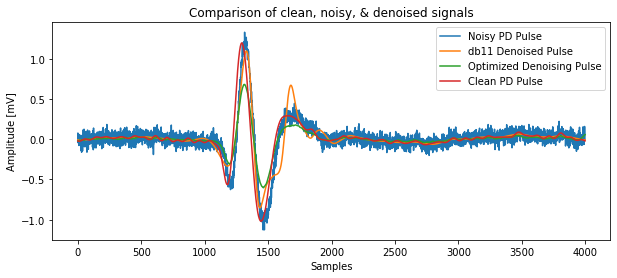

In [10]:
basic_wavelet = 'db11'
denoised = wavelet_denoising()
denoised = savitzky_golay(denoised,65,0)
print("SNR: "+ str(SNR(clean_signal_upsampled, denoised)))
print("MSE: "+ str(MSE(clean_signal_upsampled, denoised)))
print("CC: "+ str(CC(clean_signal_upsampled, denoised)))
plot_denoised(denoised, basic_wavelet)

### 11. End of script

Completion status is presented, and timer is ended here.

In [11]:
end = timer()
elapsed = end-start
print("\n===DENOISING COMPLETED===")
print("Elapsed Time: ",elapsed,"secs\n")


===DENOISING COMPLETED===
Elapsed Time:  0.31432259999928647 secs



## *Conclusion*

This concludes the optimized wavelet denoising process for the noise-contaminated PD signals.
The results show that ...